In [1]:
import astropy
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as un
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings("ignore")

In [2]:
def center(hdu):
    center_dict = {};
    center_dict = {"centpxl_ra": hdu.header['CRPIX1'], "centpxl_dec": hdu.header['CRPIX2'],
            "center_ra": hdu.header['CRVAL1'], "center_dec": hdu.header['CRVAL2'],
            "scale_ra": hdu.header['CDELT1'], "scale_dec": hdu.header['CDELT2'],
            "npxl_ra": hdu.header['NAXIS1'], "npxl_dec": hdu.header['NAXIS2']};
    
    return(center_dict)


def beam(hdu):
    beam_dict = {};
    beam_dict = {"b_major": hdu.header['BMAJ'], "b_minor": hdu.header['BMIN'], "b_pa": hdu.header['BPA']};
    #All units in degree
    
    return(beam_dict)


def info(hdu):
    info_dict = {};
    info_dict = { "obs_code": hdu.header['OBSERVER'], "obs_date": hdu.header['DATE-OBS'],
                 "obsra": hdu.header['OBSRA'], "obsdec": hdu.header['OBSDEC'],
                 "rms": hdu.header['NOISE'], "min": hdu.header['DATAMIN'], "max": hdu.header['DATAMAX']};
    
    return(info_dict)

def load(filename):
    hdu = fits.open(filename)[0];
    hdu_data = hdu.data[0][0];
    wcs_tmp = WCS(hdu.header);
    wcs_tmp1 = wcs_tmp.dropaxis(3);
    wcs = wcs_tmp1.dropaxis(2);
    
    return(hdu_data, wcs, hdu)

def cut(data, wcs, hdu, center, box):
    size = un.Quantity(box, un.pix);
    cutout = Cutout2D(data, position=center, size=size, wcs=wcs);
    hdu.header.update(cutout.wcs.to_header());
    hdu.data = cutout.data;
    wcs_cut = WCS(hdu.header);
    
    return(hdu.data, wcs_cut, hdu)

def scale(hdu, beam_dict, size):
    b_conv = (3600*1e3);
    beamsize = (beam_dict['b_major']*b_conv);
    sbar_scale = (size/beamsize);
    width = (beam_dict['b_major']*sbar_scale);

    return(width);

### V1674HERB

In [3]:
imgb_data, wcsb, imageb = load('./V1674HERIMG/V1674HERB_CLN2.hits');

imgb_inho = inho(imageb);
beamb = beam(imageb);
centerb = center(imageb);


In [4]:
cutb_data, cut_wcsb, cutb_hdu = cut(imgb_data, wcsb, imageb,
                                    center=(460, centerb['centpxl_dec']), box=(350,350));
sbar_width = scale(cutb_hdu, beamb, 10);


In [5]:
centerb_new = center(cutb_hdu);

In [7]:
# ploting functions
def beam_plotter(ra_offset, dec_offset, beam_dict, center_dict):
    
    beam_ra = (center_dict['center_ra'] - ra_offset*center_dict['scale_ra'] + beam_dict['b_major']);
    beam_dec = (center_dict['center_dec'] - dec_offset*center_dict['scale_dec'] + beam_dict['b_major']);
    
    beam = Ellipse((beam_ra, beam_dec), height=beam_dict['b_major'], width = beam_dict['b_minor'], 
                   angle=beam_dict['b_pa'], transform=axb.get_transform('fk5'), edgecolor='w',
                   facecolor='w', alpha=0.7, lw=2);
    return(beam)

def sbar_plotter(sbar_ra_offset, sbar_dec_offset, center_dict, beam_dict, sbarwidth,
                 finetune_ra=0, finetune_dec=0):

    sbar_rad = (center_dict['center_ra'] + sbar_ra_offset*center_dict['scale_ra']);
    sbar_dec = (center_dict['center_dec'] - sbar_dec_offset*center_dict['scale_dec']);
    sbar_ra_txt = (sbar_ra_offset/2 -5 + finetune_ra);
    sbar_dec_txt = (sbar_dec_offset-5 + finetune_dec);
    sbar_txt_rad = (center_dict['center_ra'] + sbar_ra_txt*center_dict['scale_ra']);
    sbar_txt_dec = (center_dict['center_dec'] - sbar_dec_txt*center_dict['scale_dec']);

    sbar = Rectangle((sbar_rad, sbar_dec), width = sbar_width, height = beam_dict['b_minor']/10,
              transform=axb.get_transform('fk5'), color='w', facecolor='w', lw=2);
                     
    return(sbar, sbar_txt_rad, sbar_txt_dec);
    

In [8]:
gaia_df = pd.read_csv('1688075645690O-result.csv', delimiter=',');
v1674her_df = gaia_df.iloc[3];
v1674her_gaia = v1674her_df.to_dict();
#ra_pm = un.Quantity(v1674her_gaia['pmra'], unit=(un.mas/un.year));

gaia = SkyCoord(v1674her_gaia['ra'], v1674her_gaia['dec'], unit=(un.degree, un.degree), 
                obstime="J2016", pm_ra_cosdec=(v1674her_gaia['pmra']*(un.mas/un.year)), 
                pm_dec=(v1674her_gaia['pmdec']*(un.mas/un.year)));


shifted_gaia_tmp = gaia.apply_space_motion(new_obstime=astropy.time.Time(imgb_info['obs_date']));
shifted_gaia = shifted_gaia_tmp.transform_to('fk5'); #AIPS uses FK5
shifted_gaia

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (284.37907711, 16.89430849)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-4.12892106, -4.67524041, 0.00049876)>

In [9]:
dihmap = SkyCoord(284.3790725790, 16.8943023350, unit=(un.degree, un.degree), 
                obstime="J2000");

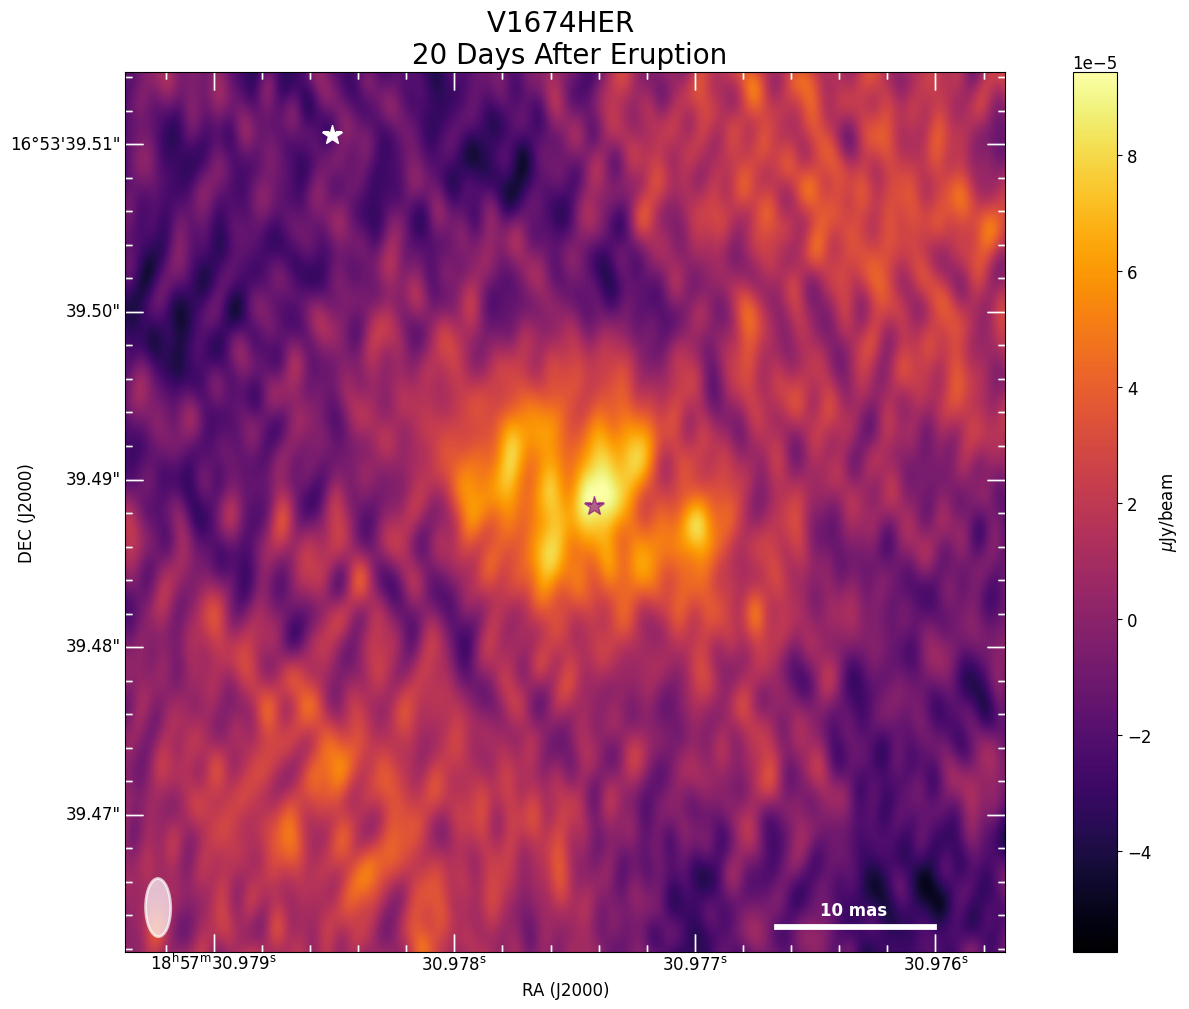

In [10]:
#intial stuff
plt.rcParams.update({'font.size': 12});


figb = plt.figure(figsize=(17,11));
axb = figb.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsb, slices=('x','y',1,1));
ra_b = axb.coords[0];
dec_b = axb.coords[1];

axb.set_title(f'V1674HER \n 20 Days After Eruption', fontsize=20);

#axes ticks
dec_b.display_minor_ticks(True);
ra_b.display_minor_ticks(True);
axb.tick_params(which='both', direction='in', color='white', length=13, width=1);
axb.tick_params(which='minor', length=5);


imgb = axb.imshow(cutb_data, cmap='inferno', vmin=imgb_info['min'], vmax=imgb_info['max'], 
                 transform=axb.get_transform(cut_wcsb[0,0]), origin='lower');

cbar_b = figb.colorbar(imgb, location='right');
cbar_b.ax.set_ylabel(r'$\mu$Jy/beam');

ra_b.set_axislabel('RA (J2000)', minpad=1);
dec_b.set_axislabel('DEC (J2000)', minpad=-1.0);

beam_patch = beam_plotter(200,180, beamb, centerb);
scale_bar, sbar_txt_rad, sbar_txt_dec = sbar_plotter(100,165, centerb, beamb, 10, finetune_ra=7);
sbartxt = '10 mas';

axb.add_patch(beam_patch);
axb.text(sbar_txt_rad, sbar_txt_dec, sbartxt, transform=axb.get_transform('fk5'), color='w', weight='bold');
axb.add_patch(scale_bar);



axb.plot(shifted_gaia.ra.degree, shifted_gaia.dec.degree, transform=axb.get_transform('fk5'), 
         markersize=15, color='white', marker='*', label='Gaia position');
# axb.plot(centerb_new['center_ra'], centerb_new['center_dec'], transform=axb.get_transform('fk5'), 
#          markersize=15, color='white', alpha=0.7, marker='*', label='Gaia position');

axb.plot(difmap.ra.degree, difmap.dec.degree, transform=axb.get_transform('fk5'), 
         markersize=15, color='purple', alpha=0.6, marker='*', label='Difmap Center Position');

### V1674HERD

In [11]:
imgd_data, wcsd, imaged = load('./V1674HERIMG/V1674HERD_CLN.fits');

imgd_info = info(imaged);
beamd = beam(imaged);
centerd = center(imaged);

cutd_data, cut_wcsd, cutd_hdu = cut(imgd_data, wcsd, imaged,
                                    center=(556, 499), box=(350,350));
center_newd = center(cutd_hdu);
sbar_widthd = scale(cutd_hdu, beamd, 10);

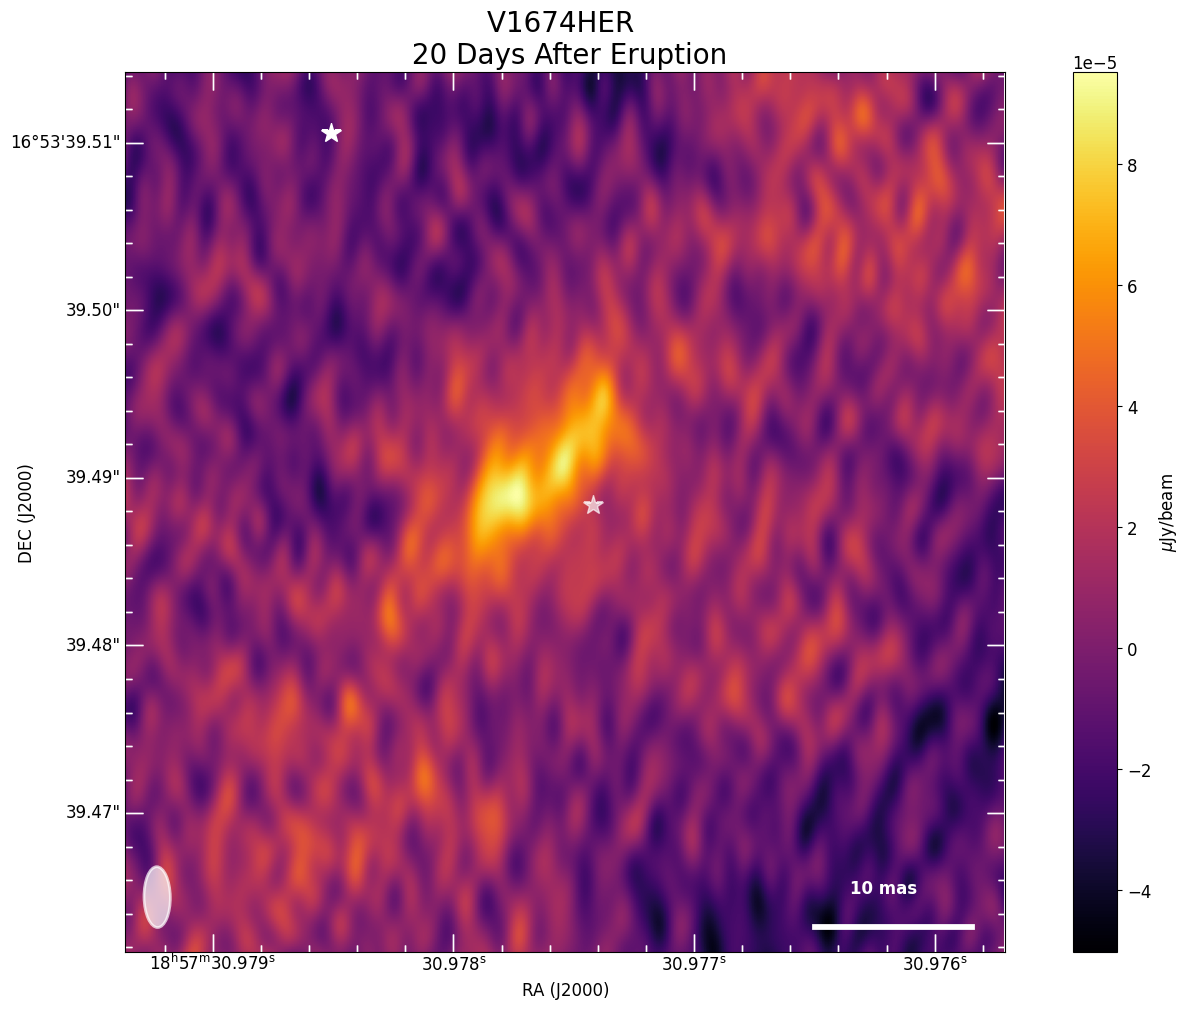

In [12]:
figd = plt.figure(figsize=(17,11));
axd = figd.add_axes([0.2, 0.2, 0.8, 0.8], projection=cut_wcsd, slices=('x','y',1,1));
ra_d = axd.coords[0];
dec_d = axd.coords[1];

axd.set_title(f'V1674HER \n 20 Days After Eruption', fontsize=20);

#axes ticks
dec_d.display_minor_ticks(True);
ra_d.display_minor_ticks(True);
axd.tick_params(which='both', direction='in', color='white', length=13, width=1);
axd.tick_params(which='minor', length=5);


imgd = axd.imshow(cutd_data, cmap='inferno', vmin=imgd_info['min'], vmax=imgd_info['max'], 
                 transform=axd.get_transform(cut_wcsd[0,0]), origin='lower');

cbar_d = figd.colorbar(imgd, location='right');
cbar_d.ax.set_ylabel(r'$\mu$Jy/beam');

ra_d.set_axislabel('RA (J2000)', minpad=1);
dec_d.set_axislabel('DEC (J2000)', minpad=-1.0);

beam_patchd = beam_plotter(275, 255, beamd, center_newd);

scale_bard, sbard_txt_rad, sbard_txt_dec = sbar_plotter(40, 243, center_newd, beamd, 10);
sbard_txt_rad = center_newd['center_ra'] + 165 *center_newd['scale_ra']
sbard_txt_dec = center_newd['center_dec'] - 165*center_newd['scale_dec']
sdartxt = '10 mas';

axd.add_patch(beam_patchd);
axd.text(sbard_txt_rad, sbard_txt_dec, sbartxt, transform=axd.get_transform('fk5'), color='w', weight='bold');

axd.add_patch(scale_bard);



axd.plot(shifted_gaia.ra.degree, shifted_gaia.dec.degree, transform=axd.get_transform('fk5'), 
         markersize=15, color='white', marker='*', label='Gaia position');

axd.plot(difmap.ra.degree, difmap.dec.degree, transform=axd.get_transform('fk5'), 
         markersize=15, color='white', marker='*', alpha=0.65, label='V1674HER position');

### V1674HERh

In [15]:
imgf_data, wcsf, imagef = load('./V1674HERIMG/V1674HERF_CLN3.fits');

imgf_info = info(imagef);
beamf = beam(imagef);
centerf = center(imagef);

cutf_data, cutf_wcs, cutf_hdu = cut(imgf_data, wcsf, imagef,
                                    center=(490, 435), box=(350,350));

centerf_new = center(cutf_hdu);

sbarf_width = scale(cutf_hdu, beamf, 10);


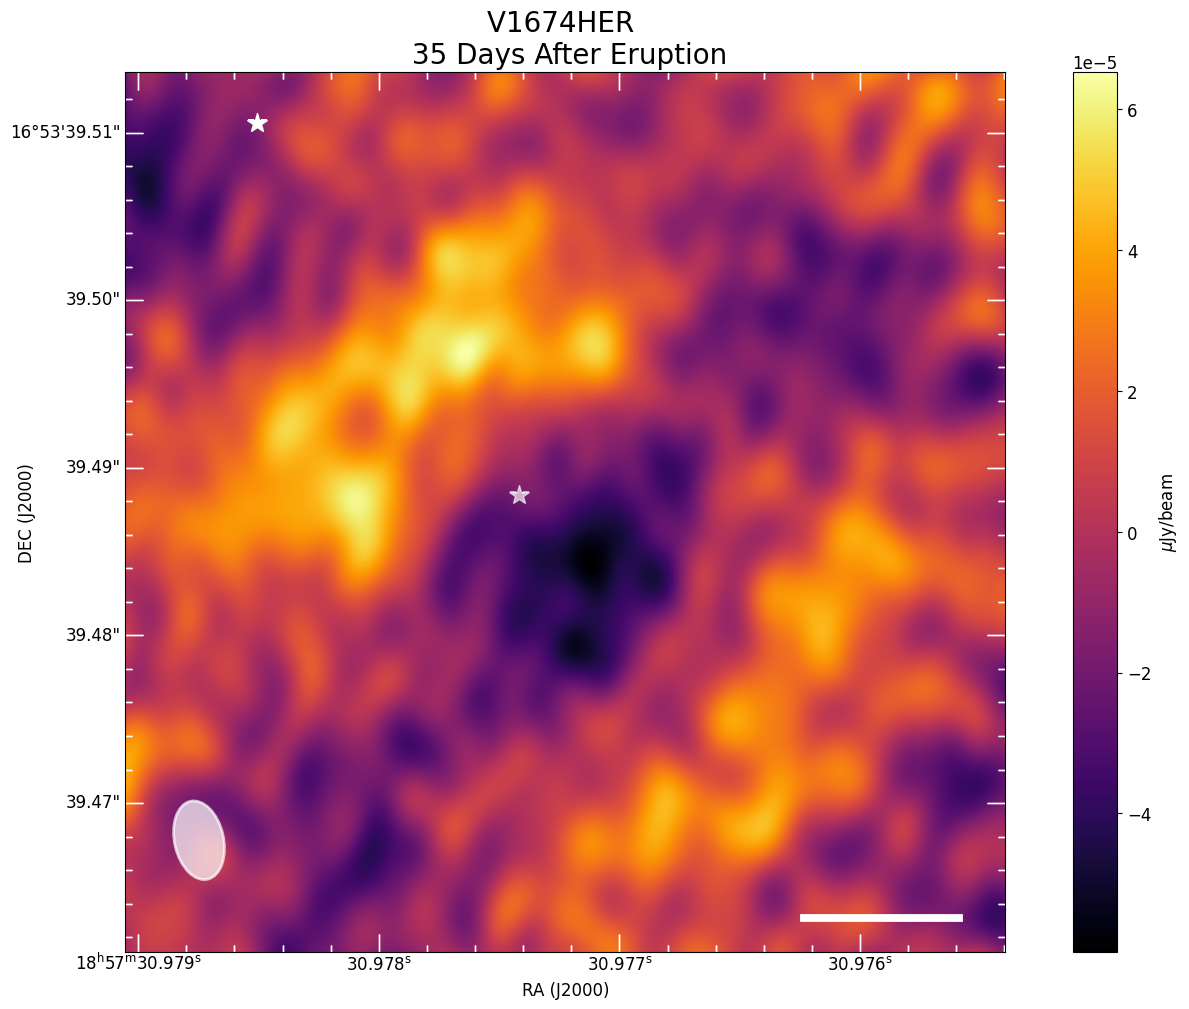

In [16]:
figf = plt.figure(figsize=(17,11));
axf = figf.add_axes([0.2, 0.2, 0.8, 0.8], projection=cutf_wcs, slices=('x','y', 1,1));
ra_f = axf.coords[0];
dec_f = axf.coords[1];

axf.set_title(f'V1674HER \n 35 Days After Eruption', fontsize=20);

dec_f.display_minor_ticks(True);
ra_f.display_minor_ticks(True);
axf.tick_params(which='both', direction='in', color='white', length=13, width=1);
axf.tick_params(which='minor', length=5);

imgf = axf.imshow(cutf_data, cmap='inferno', vmin=imgf_info['min'], vmax=imgf_info['max'],
                  transform=axf.get_transform(cutf_wcs[0,0]), origin='lower');

cbar_f = figf.colorbar(imgf, location='right');
cbar_f.ax.set_ylabel(r'$\mu$Jy/beam');

ra_f.set_axislabel('RA (J2000)', minpad=1);
dec_f.set_axislabel('DEC (J2000)', minpad=-1.0);

beam_patchf = beam_plotter(350, 300, beamf, centerf_new);

axf.add_patch(beam_patchf);
scalef_bar, sbarf_txt_ra, sbarf_txt_dec = sbar_plotter(-65, 300, centerf_new, beamf, 10);
axf.add_patch(scalef_bar);

axf.plot(shifted_gaia.ra.degree, shifted_gaia.dec.degree, transform=axf.get_transform('fk5'), 
         markersize=15, color='white', marker='*', label='Gaia position');


axf.plot(difmap.ra.degree, difmap.dec.degree,  transform=axf.get_transform('fk5'), 
         markersize=15, color='white', marker='*', alpha=0.65, label='V1674HER position');

In [37]:
imgh_data, wcsh, imageh = load('./V1674HERIMG/V1674HERH_CLN.fits');

imgh_info = info(imageh);
beamh = beam(imageh);
centerh = center(imageh);

cuth_data, cuth_wcs, cuth_hdu = cut(imgh_data, wcsh, imageh,
                                    center=difmap, box=(350,350));

centerh_new = center(cuth_hdu);

sbarh_width = scale(cuth_hdu, beamh, 10);

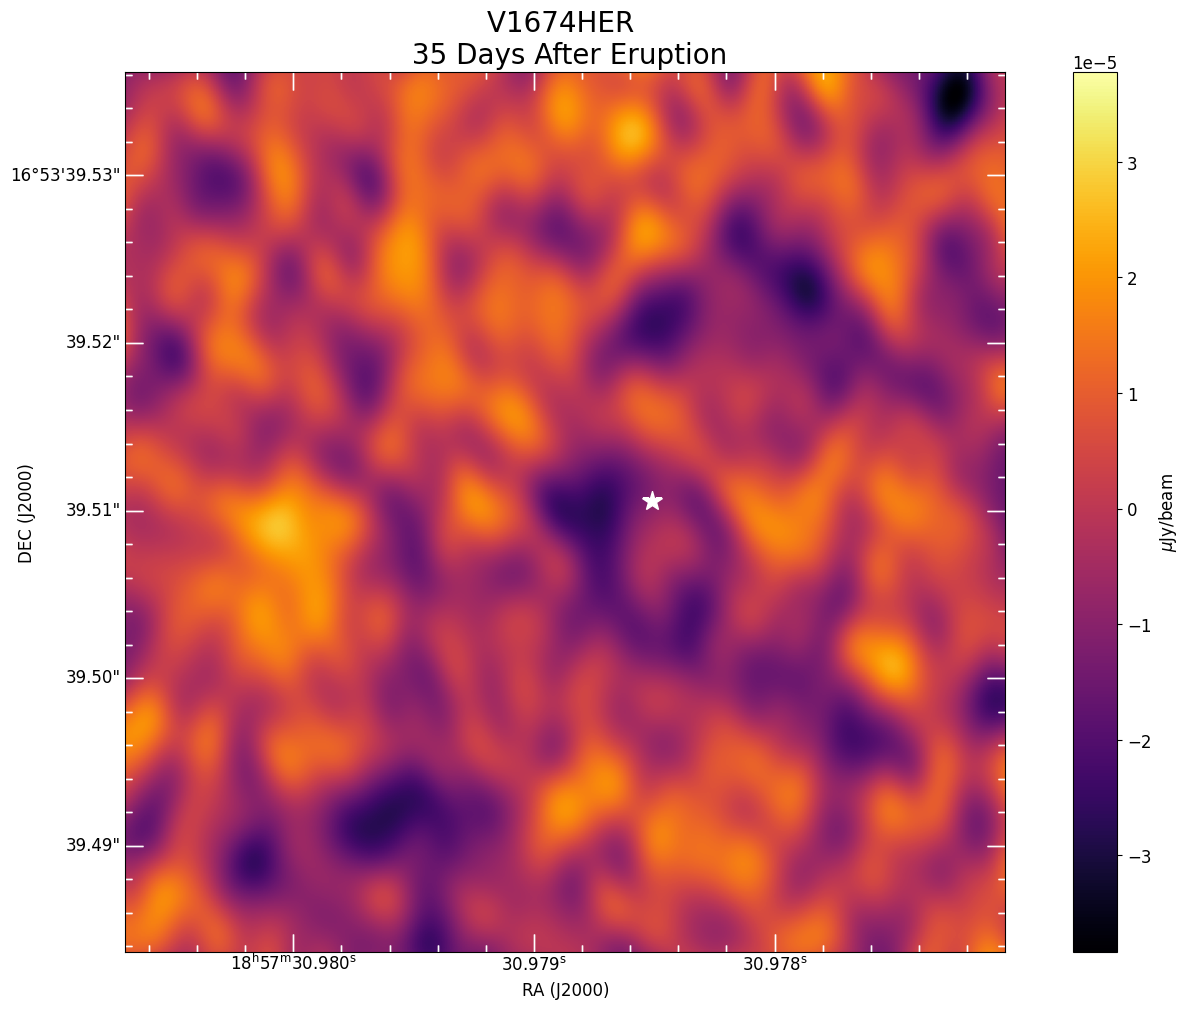

In [38]:
figh = plt.figure(figsize=(17,11));
axh = figh.add_axes([0.2, 0.2, 0.8, 0.8], projection=cuth_wcs, slices=('x','y', 1,1));
ra_h = axh.coords[0];
dec_h = axh.coords[1];

axh.set_title(f'V1674HER \n 35 Days After Eruption', fontsize=20);

dec_h.display_minor_ticks(True);
ra_h.display_minor_ticks(True);
axh.tick_params(which='both', direction='in', color='white', length=13, width=1);
axh.tick_params(which='minor', length=5);

imgh = axh.imshow(cuth_data, cmap='inferno', vmin=imgh_info['min'], vmax=imgh_info['max'],
                  transform=axh.get_transform(cuth_wcs[0,0]), origin='lower');

cbar_h = figh.colorbar(imgh, location='right');
cbar_h.ax.set_ylabel(r'$\mu$Jy/beam');

ra_h.set_axislabel('RA (J2000)', minpad=1);
dec_h.set_axislabel('DEC (J2000)', minpad=-1.0);

beam_patchh = beam_plotter(350, 350, beamh, centerh_new);

#axh.add_patch(beam_patchh);
# scaleh_bar, sbarh_txt_ra, sbarh_txt_dec = sbar_plotter(-65, 300, centerh_new, beamh, 10);
# axh.add_patch(scaleh_bar);

axh.plot(shifted_gaia.ra.degree, shifted_gaia.dec.degree, transform=axh.get_transform('fk5'), 
         markersize=15, color='white', marker='*', label='Gaia position');


# axh.plot(difmap.ra.degree, difmap.dec.degree,  transform=axh.get_transform('fk5'), 
#          markersize=15, color='white', marker='*', alpha=0.65, label='V1674HER position');